In [1]:
import tqdm
import fasttext
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest


# 1. Load Data & Model

In [2]:
model_path = "Models/cbow_model.bin"
data_path = 'Data\submission_and_comments_V3.csv'
clusters_path = "Data\CBOW_KMeans_TitlesClusters_k=25-50-100-150-200-1000.csv"


all_data = pd.read_csv(data_path, sep = ";")
model = fasttext.load_model(model_path)
clusters = pd.read_csv(clusters_path)

data = all_data[(all_data.submission_title != "[deleted by user]") & ~(all_data.submission_title.isna())]
concat_posts = np.array(data['submission_title'])

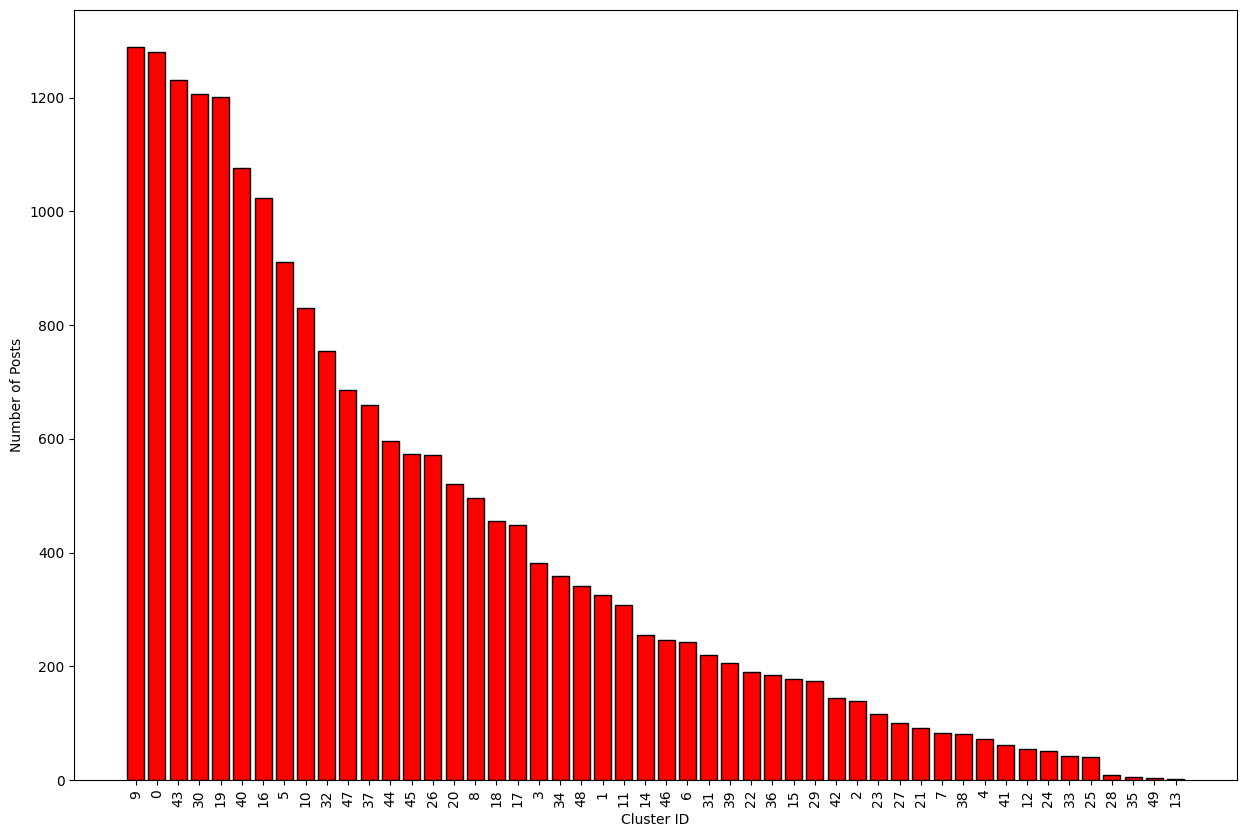

In [3]:
n_clusters = 50
chosen_clusters = clusters[['submission_title', f'KMeans_k={n_clusters}']]
count_clusters = Counter(chosen_clusters[f'KMeans_k={n_clusters}'].values)
sorted_dico = sorted([[chars, counts] for chars, counts in count_clusters.items()], key = lambda x: -x[1])
cluster_id = [x[0] for x in sorted_dico]
counts = [x[1] for x in sorted_dico]

plt.figure(figsize = (15,10))
plt.bar(range(len(count_clusters)), counts, align = 'center', color = 'r', edgecolor = 'k')
_ = plt.xticks(range(len(count_clusters)), cluster_id, rotation = "vertical")
plt.xlabel('Cluster ID')
plt.ylabel('Number of Posts')
plt.show()


In [4]:
embbed_data = [model[post] for post in concat_posts]

# 2. Isolation Forest Model

In [5]:
cluster_ids = chosen_clusters[f'KMeans_k={n_clusters}'].unique()

cluster_scores_list = []

for cluster_id in tqdm.tqdm(cluster_ids):
    cluster_index = chosen_clusters[chosen_clusters[f'KMeans_k={n_clusters}'] == cluster_id].index
    embbed_cluster = [embbed_data[ind] for ind in cluster_index]
    anomaly_model = IsolationForest(random_state=0).fit(embbed_cluster)
    cluster_scores = -anomaly_model.score_samples(embbed_cluster)
    cluster_scores_list.append(cluster_scores)

100%|██████████| 50/50 [00:06<00:00,  7.51it/s]


100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


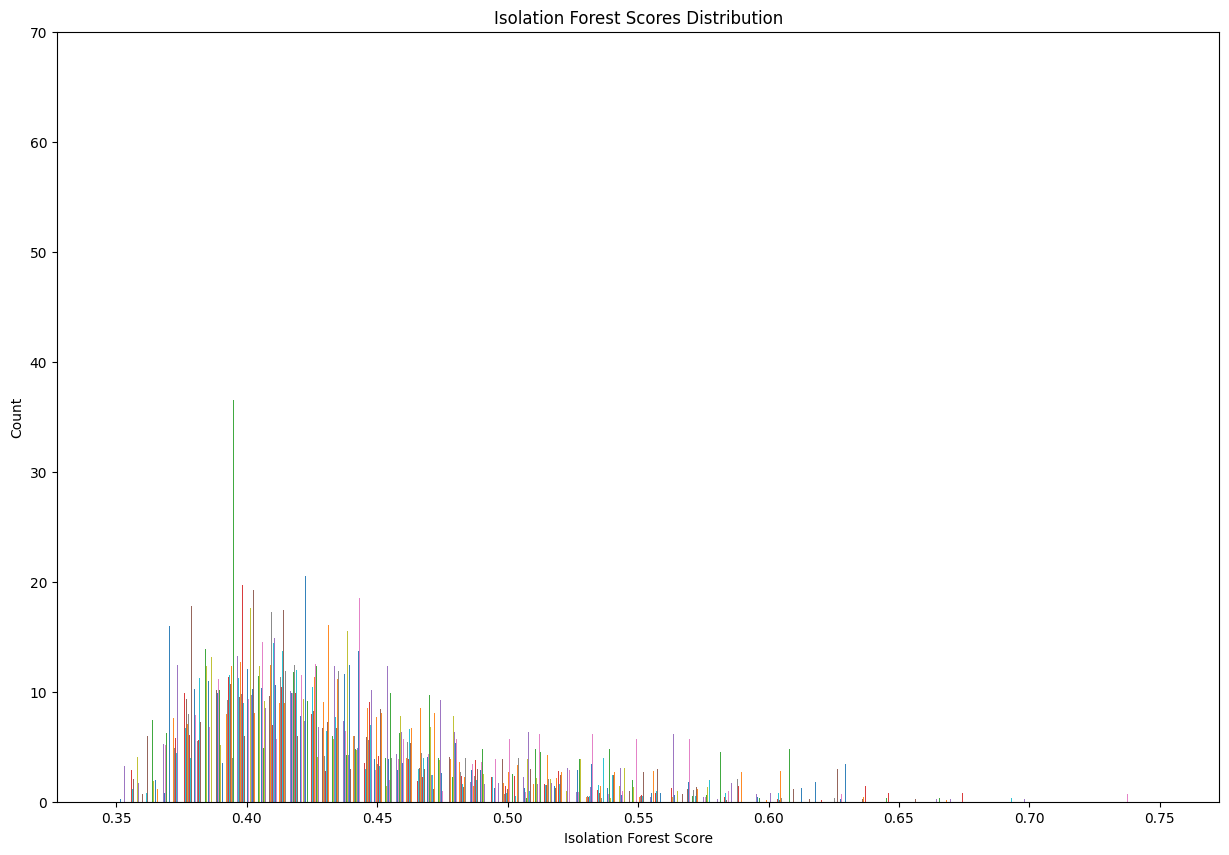

In [8]:
plt.figure(figsize = (15, 10))
for cluster_scores in tqdm.tqdm(cluster_scores_list[:10]):
    plt.hist(cluster_scores_list, bins = 100, alpha = 0.2, density = True)
plt.ylim([0,70])
plt.xlabel('Isolation Forest Score')
plt.ylabel('Count')
plt.title('Isolation Forest Scores Distribution')
plt.show()

# 3. Outliers Detection: Manual Analyis

In [40]:
cluster_id = 25

cluster_data = clusters[clusters[f'KMeans_k={n_clusters}'] == cluster_ids[cluster_id]][['submission_title',f'Top5_k={n_clusters}', f'KMeans_k={n_clusters}']]
cluster_scores = cluster_scores_list[cluster_id]
cluster_data['anomaly_score'] = cluster_scores
threshold = max(np.quantile(cluster_scores, 0.95), 0.6)
cluster_anomalies = np.where(cluster_scores >= threshold)
cluster_data.iloc[cluster_anomalies]


## Outliers: posts that are not related to the main topics treated in the cluster
## --> Not what we are looking for, i.e. distressed users

,submission_title,Top5_k=50,KMeans_k=50,anomaly_score
795,I deleted TikTok!,"['delay', 'Twitter)', 'Twitter']",36,0.650254
